In [101]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py, os
import numpy as np
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from matplotlib import pyplot as plt
import csv
import time
from skimage.measure import compare_ssim 
import pickle

In [2]:
modtype='3L_CNN'
best_model='3L_CNN_5.pth'
model_base_path='/home/students/lxr863/NeuralComp_G42-master/'+modtype
test_file_path='/data/local/NC2019MRI/test'
data_path_train='/data/local/NC2019MRI/train'
data_path_val='/data/local/NC2019MRI/train'

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
print(device)

cuda:0


In [4]:
if modtype=='3L_CNN':
    class CNN_3L(nn.Module):
        def __init__(self):
            super(CNN_3L,self).__init__()
            ### Patch Extraction n1=64 c=1 f1=9
            self.block1=nn.Conv2d(1,64,kernel_size=9,padding=2)
            ### Non-Linear Mapping n2=n1=64 f2=1
            self.block2=nn.Conv2d(64,32,kernel_size=1,padding=2)
            ### Image Reconstruction n3=n2=32 f3=5
            self.block3=nn.Conv2d(32,1,kernel_size=5,padding=2)
            self.RELU=nn.ReLU()
        def forward(self,out):
            out=self.block1(out)
            out=self.RELU(out)
            out=self.block2(out)
            out=self.RELU(out)
            out=self.block3(out)
            return out
    print('3L_CNN')
elif modtype=='4L_CNN':
    class CNN_4L(nn.Module):
        def __init__(self):
            super(CNN_4L,self).__init__()
            ### Patch Extraction n1=64 c=1 f1=9
            self.block1=nn.Conv2d(1,64,kernel_size=9,padding=2)
            ### Non-Linear Mapping n2=n1=64 f2=1
            self.block2=nn.Conv2d(64,64,kernel_size=1,padding=2)
            ### Image Reconstruction n3=n2=32 f3=5
            self.block3=nn.Conv2d(64,32,kernel_size=5,padding=2)
            ### Image Reconstruction n4=n=32 f3=3
            self.block4=nn.Conv2d(32,1,kernel_size=3,padding=1)
            self.RELU=nn.ReLU()
        def forward(self,out):
            out=self.block1(out)
            out=self.RELU(out)
            out=self.block2(out)
            out=self.RELU(out)
            out=self.block3(out)
            out=self.RELU(out)
            out=self.block4(out)
            return out
    print('4L_CNN')
elif modtype=='UNet' or modtype=='DCGAN':
    class DoubleConv(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        def forward(self, x):
            return self.double_conv(x)

    class Down(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.maxpool_conv = nn.Sequential(
                nn.MaxPool2d(2),
                DoubleConv(in_channels, out_channels)
            )
        def forward(self, x):
            return self.maxpool_conv(x)

    class Up(nn.Module):
        def __init__(self, in_channels, out_channels, bilinear=True):
            super().__init__()
            if bilinear:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            else:
                self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        def forward(self, x1, x2):
            x1 = self.up(x1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
            return self.conv(x)

    class OutConv(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(OutConv, self).__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        def forward(self, x):
            return self.conv(x)

    class UNet(nn.Module):
        def __init__(self, n_channels, n_classes, bilinear=True):
            super(UNet, self).__init__()
            self.n_channels = n_channels
            self.n_classes = n_classes
            self.bilinear = bilinear
            self.inc = DoubleConv(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            self.down4 = Down(512, 512)
            self.up1 = Up(1024, 256, bilinear)
            self.up2 = Up(512, 128, bilinear)
            self.up3 = Up(256, 64, bilinear)
            self.up4 = Up(128, 64, bilinear)
            self.outc = OutConv(64, n_classes)
        def forward(self, x):
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
            return logits
        
    class Generator(nn.Module):
        def __init__(self, n_channels, n_classes, bilinear=True):
            super(Generator, self).__init__()
            self.n_channels = n_channels
            self.n_classes = n_classes
            self.bilinear = bilinear
            self.inc = DoubleConv(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            self.down4 = Down(512, 512)
            self.up1 = Up(1024, 256, bilinear)
            self.up2 = Up(512, 128, bilinear)
            self.up3 = Up(256, 64, bilinear)
            self.up4 = Up(128, 64, bilinear) 
            self.outc = OutConv(64, n_classes)
        def forward(self, x):
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
            return logits
        
    class Discriminator(nn.Module):
        def __init__(self, ngpu):
            super(Discriminator, self).__init__()
            self.ngpu = ngpu
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                nn.Conv2d(nc, ndf, 4, 3, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 3, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 3, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 0, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
                nn.Sigmoid()
            )

        def forward(self, input):
            return self.main(input)
    print('UNets')

3L_CNN


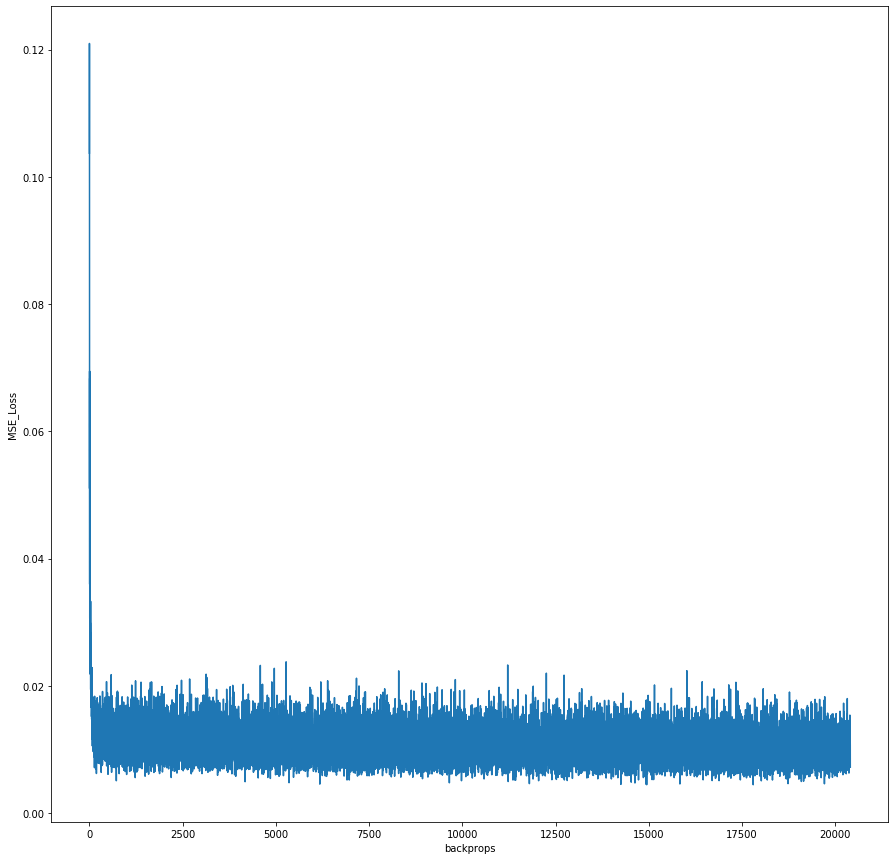

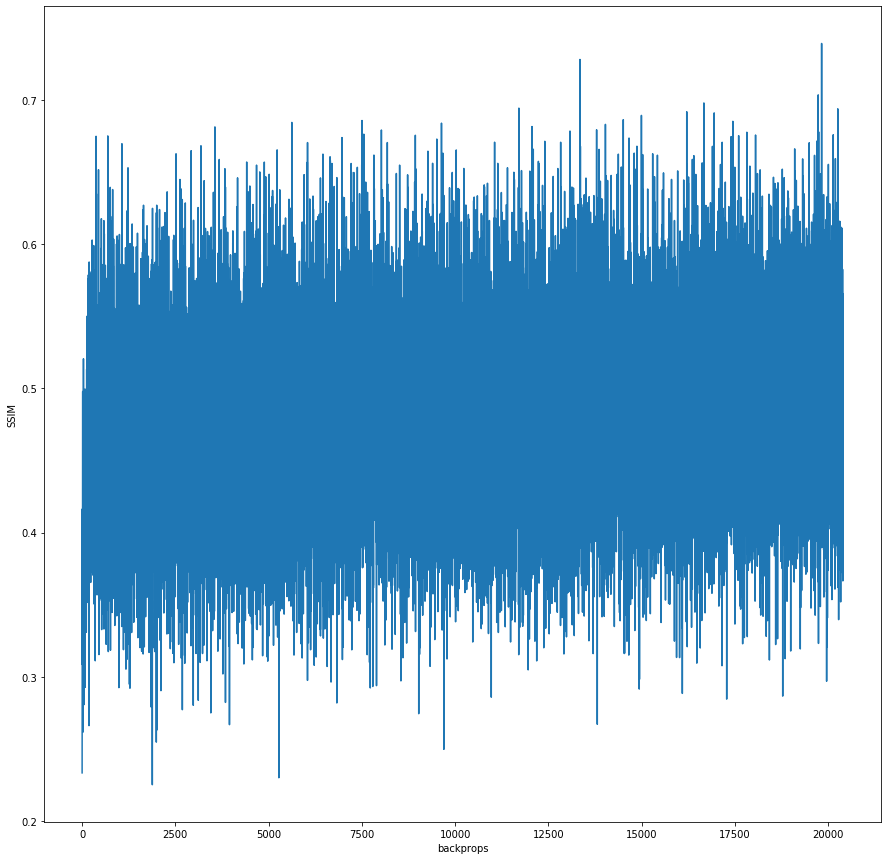

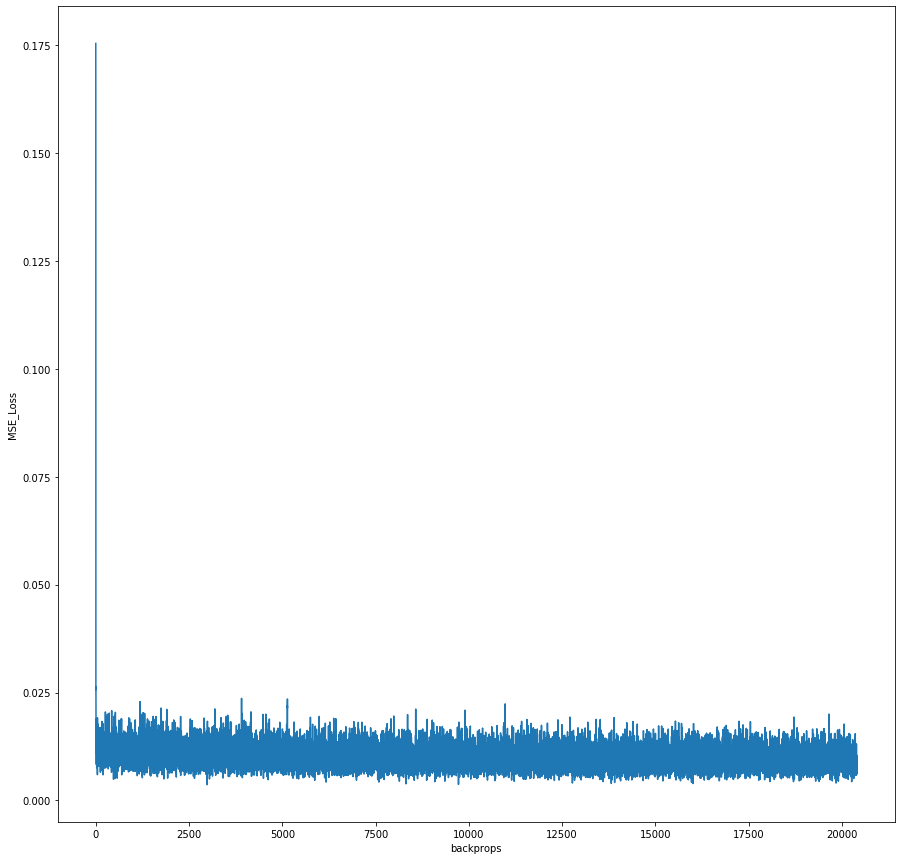

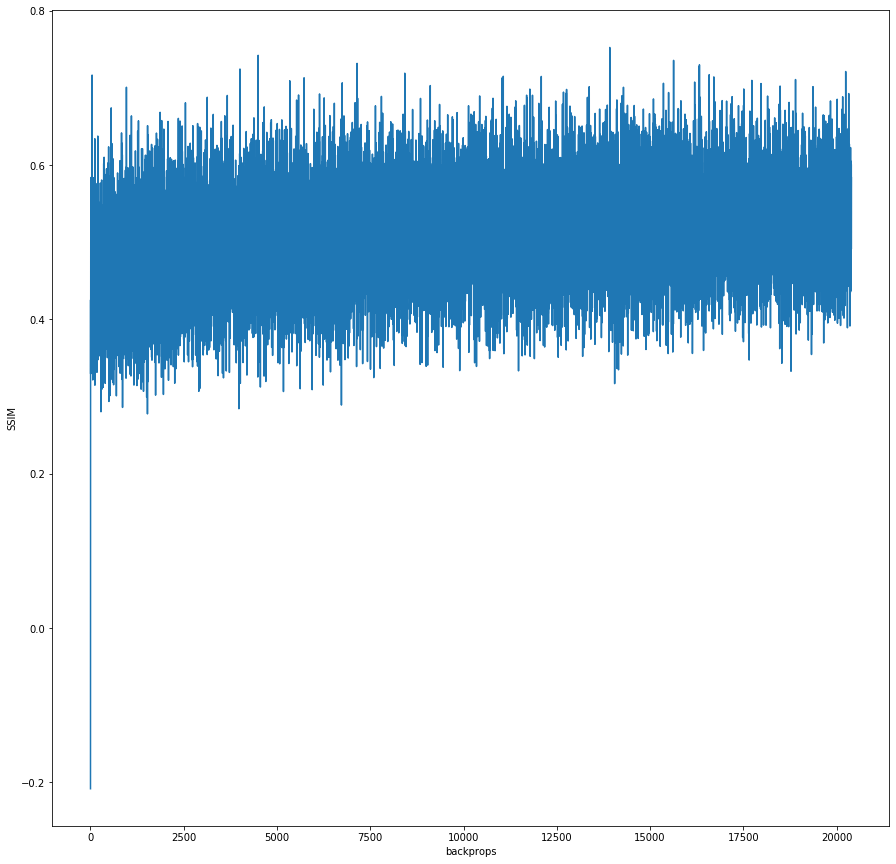

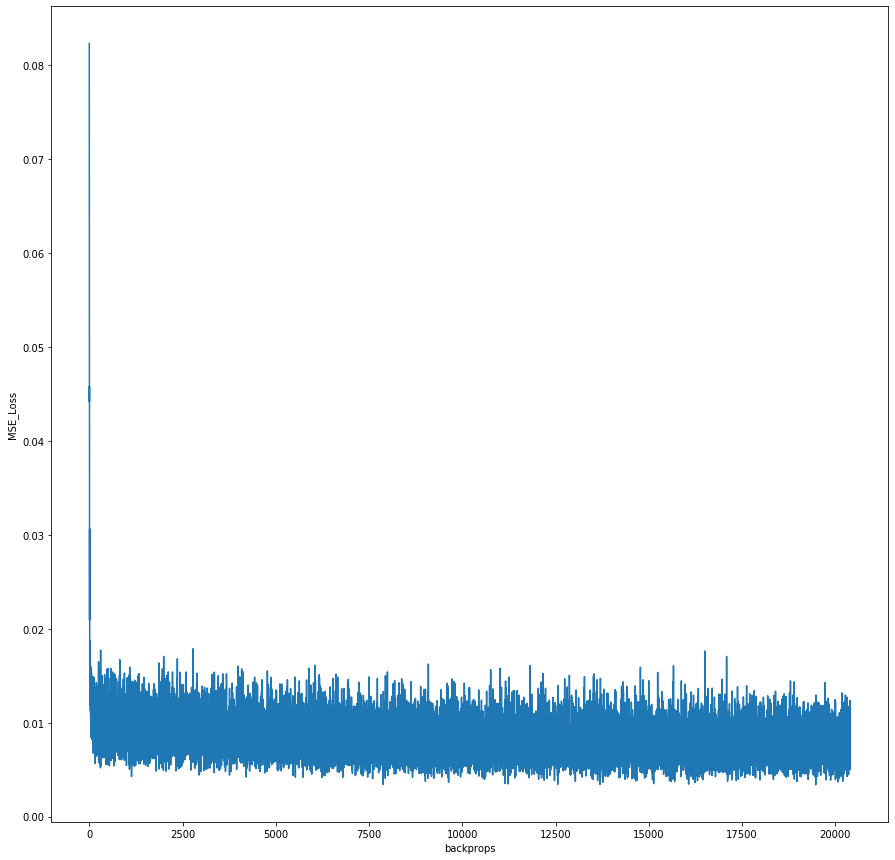

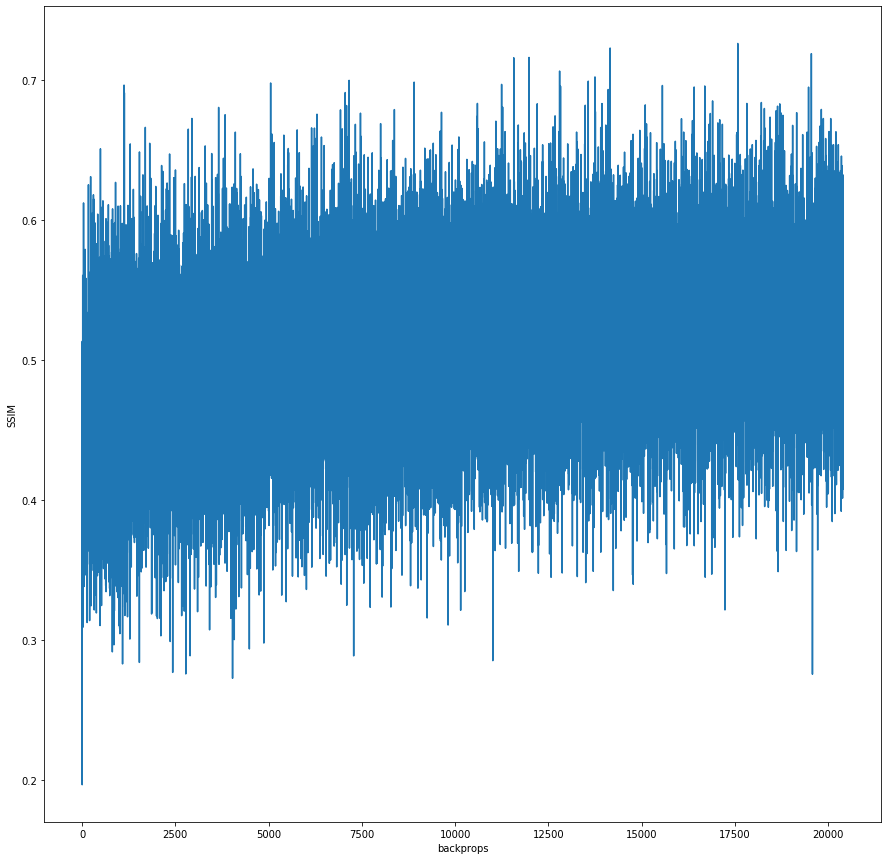

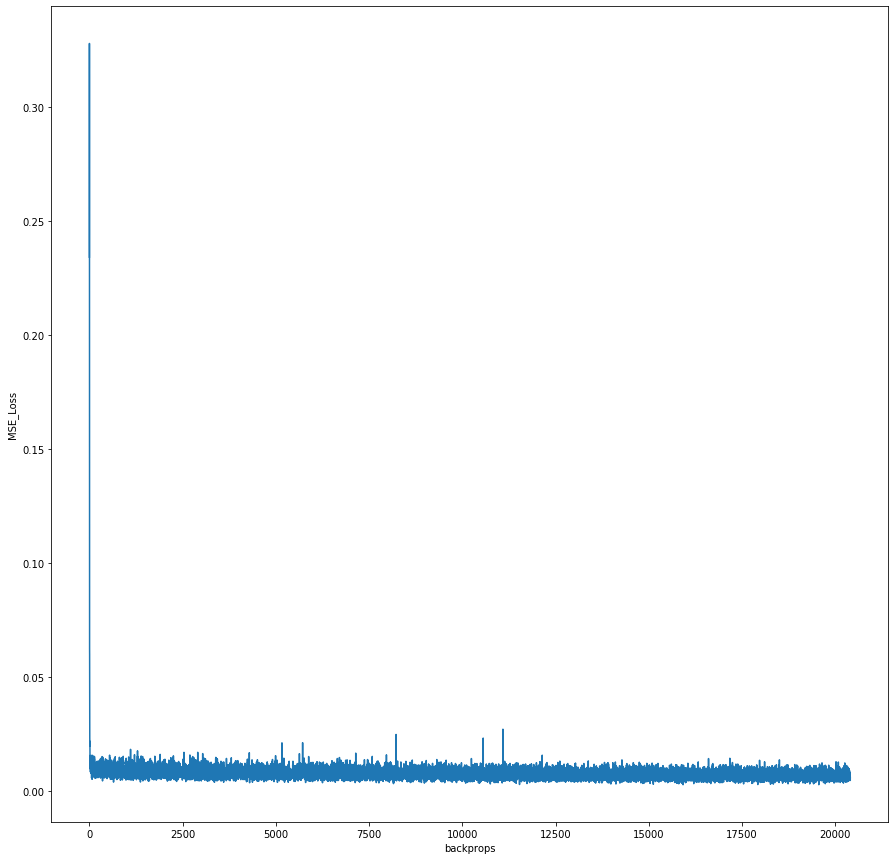

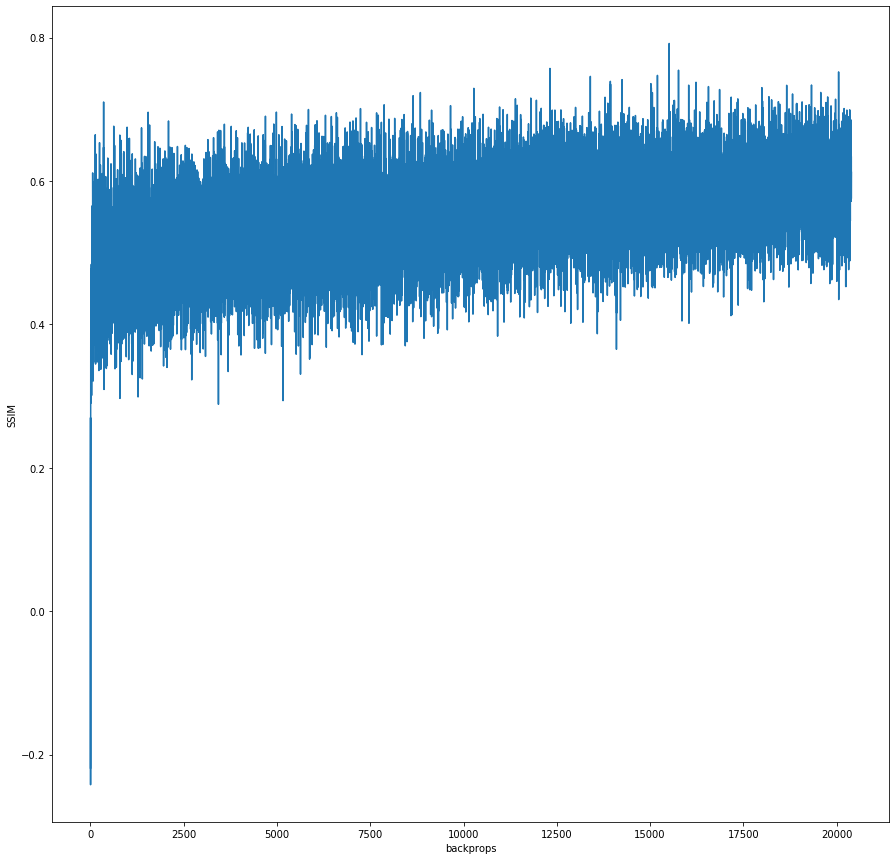

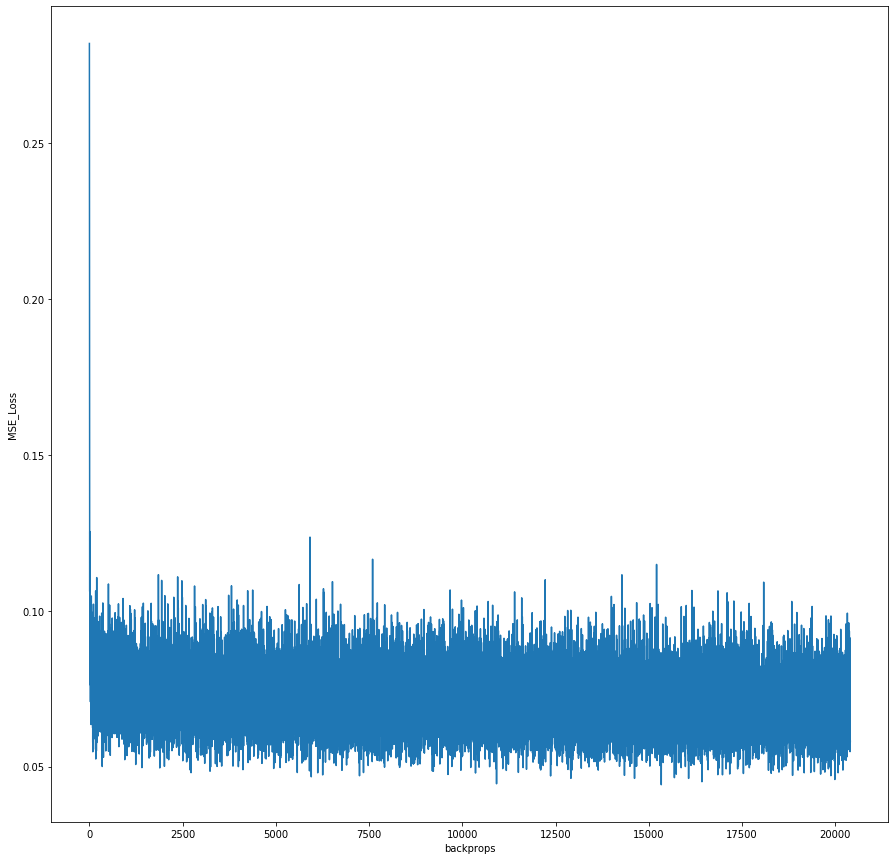

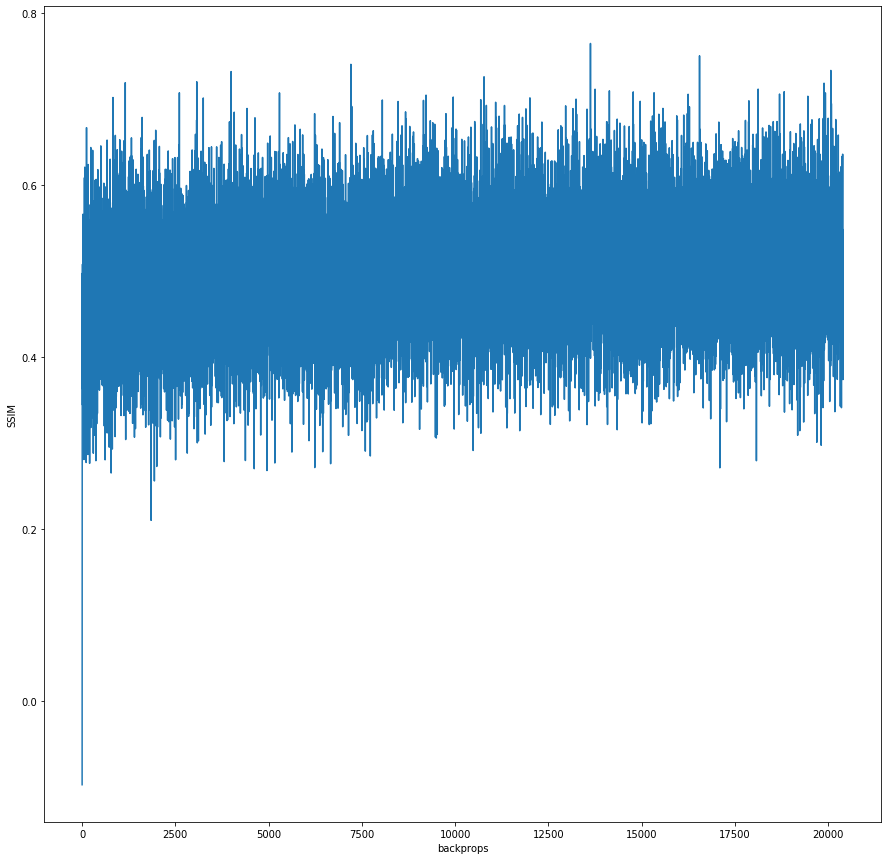

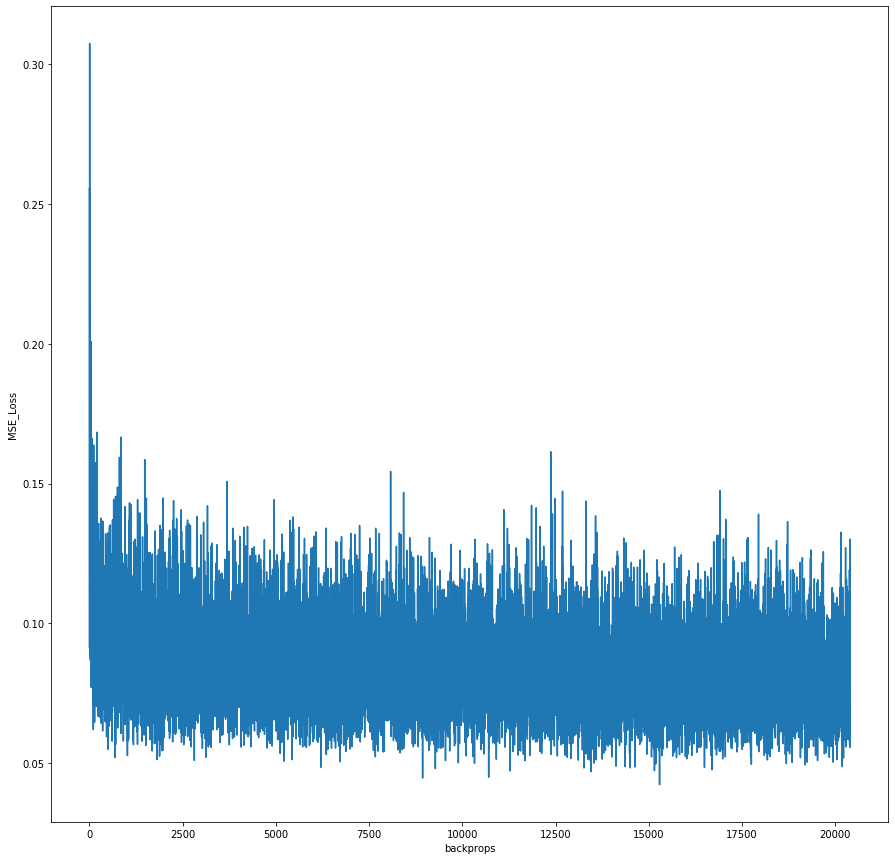

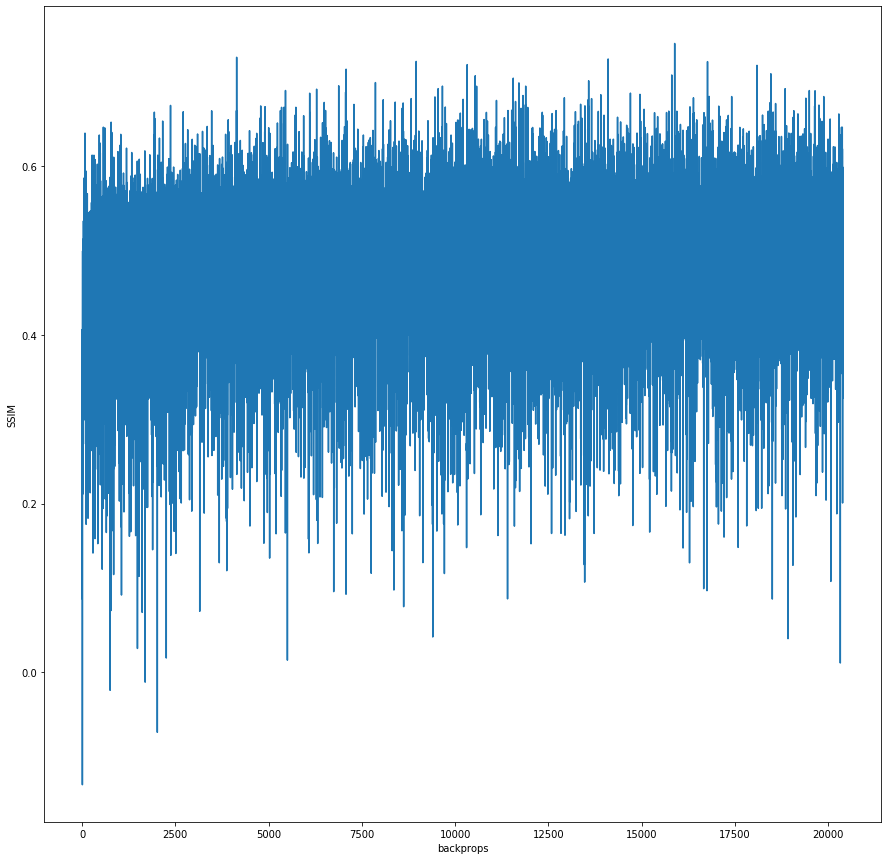

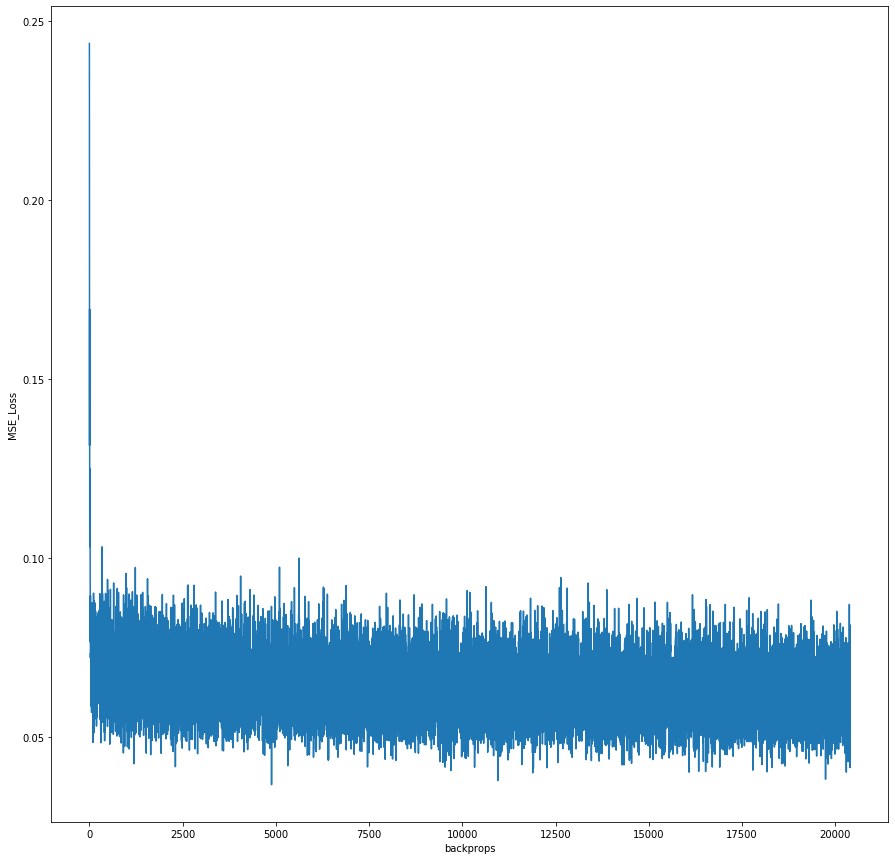

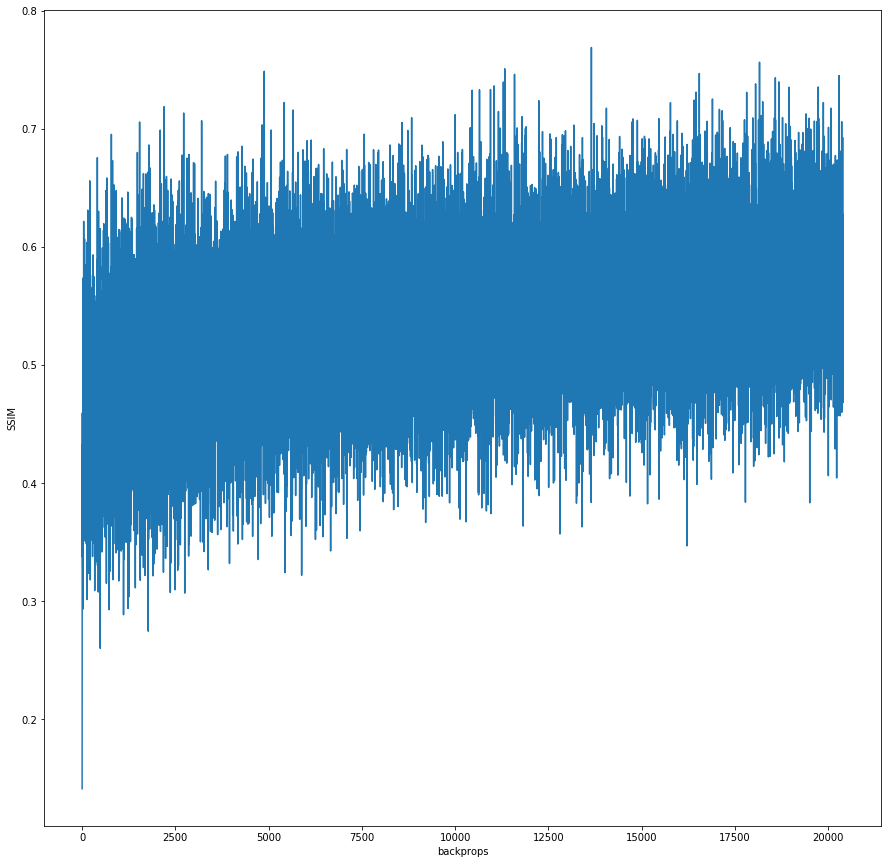

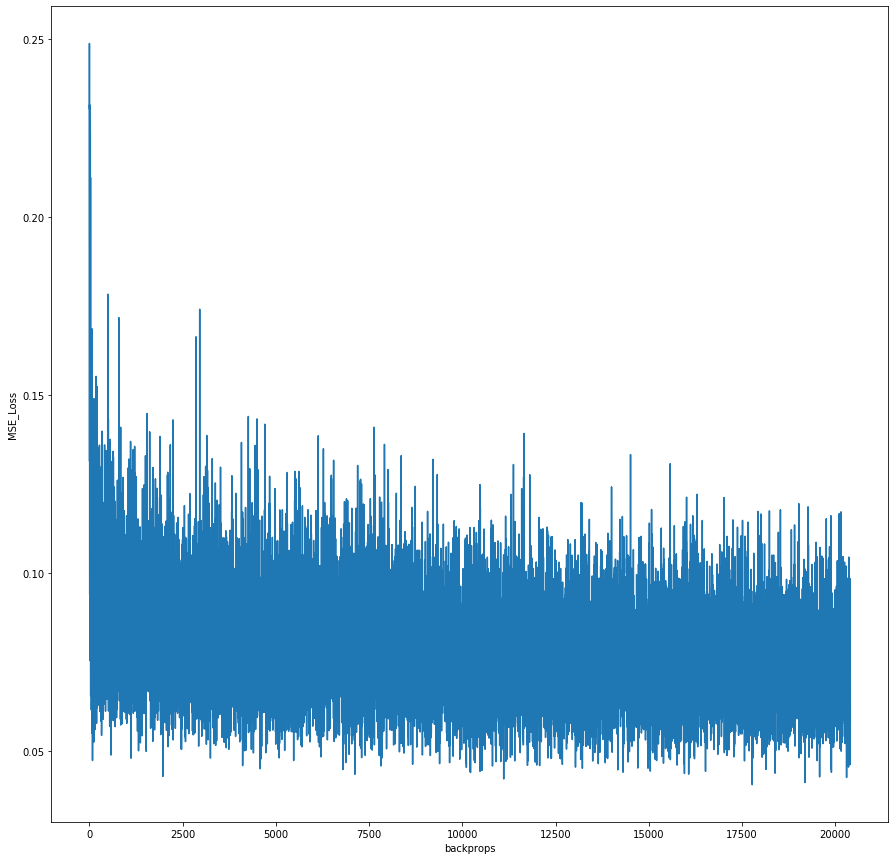

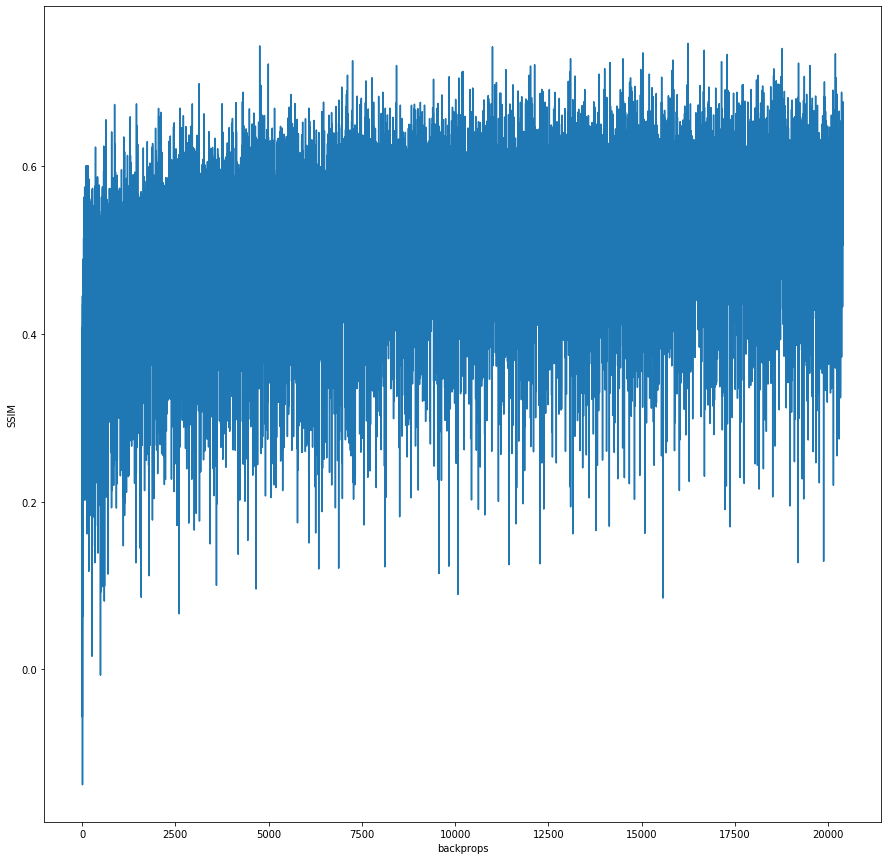

In [102]:

k=0
for fname in sorted(os.listdir(model_base_path)):
    #print('filename:',fname)
    MSE_loss=[]
    SSIM_net=[]
    if modtype=='3L_CNN':
        model=CNN_3L().to(device)
        checkpoint=(torch.load(model_base_path+'/'+fname))
        losses=checkpoint['Loss']
        SSIMval=checkpoint['SSIM']
        n=len(losses)
        m=0
        with open(fname+'.pickle','wb') as f:
            for i in range(0,n):
                if i%340==0:
                    MSE_loss.append(losses[i])
                    SSIM_net.append(SSIMval[i])
                    m+=1
            pickle.dump([MSE_loss,SSIM_net],f)
            k+=1
        plt.figure(figsize=(15,15))
        plt.plot(range(len(losses)),losses,label="Training loss")
        plt.xlabel("backprops")
        plt.ylabel("MSE_Loss")
        plt.show()
        
        
        plt.figure(figsize=(15,15))
        plt.plot(range(len(SSIMval)),SSIMval,label="SSIM")
        plt.xlabel("backprops")
        plt.ylabel("SSIM")
        plt.show()
    elif modtype=='4L_CNN':
        model=CNN_3L().to(device)
        checkpoint=(torch.load(model_base_path+'/'+fname))
        losses=checkpoint['Loss']
        SSIMval=checkpoint['SSIM']
        n=len(losses)
        k=0
        for i in range(0,n):
            if i%340==0:
                MSE_Loss[fname][k:k+1]=losses[i]
                k+=1
    elif modtype=='UNet' or modtype=='DCGAN':
        model=Generator(1,1).to(device) 
f.close()

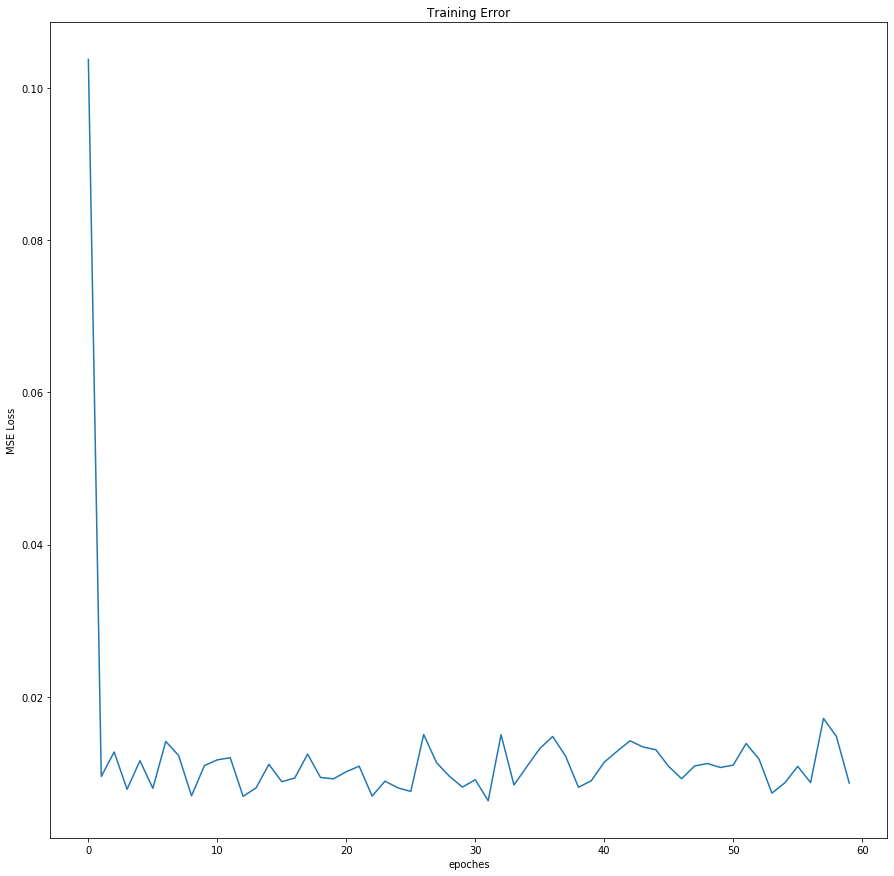

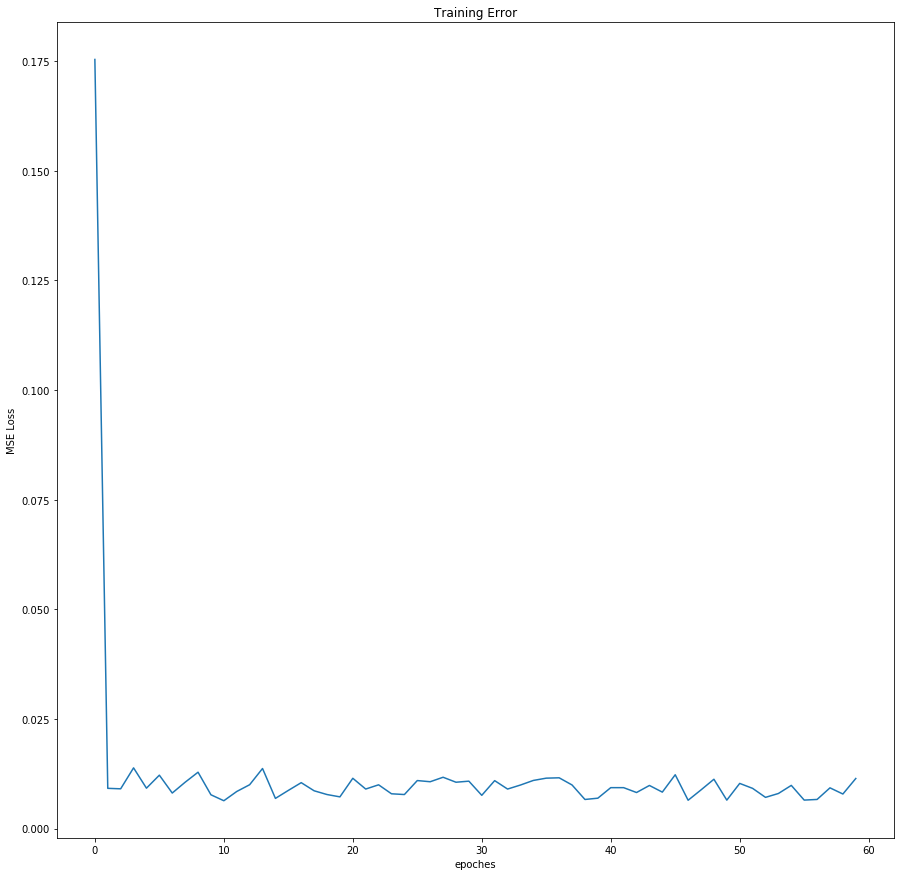

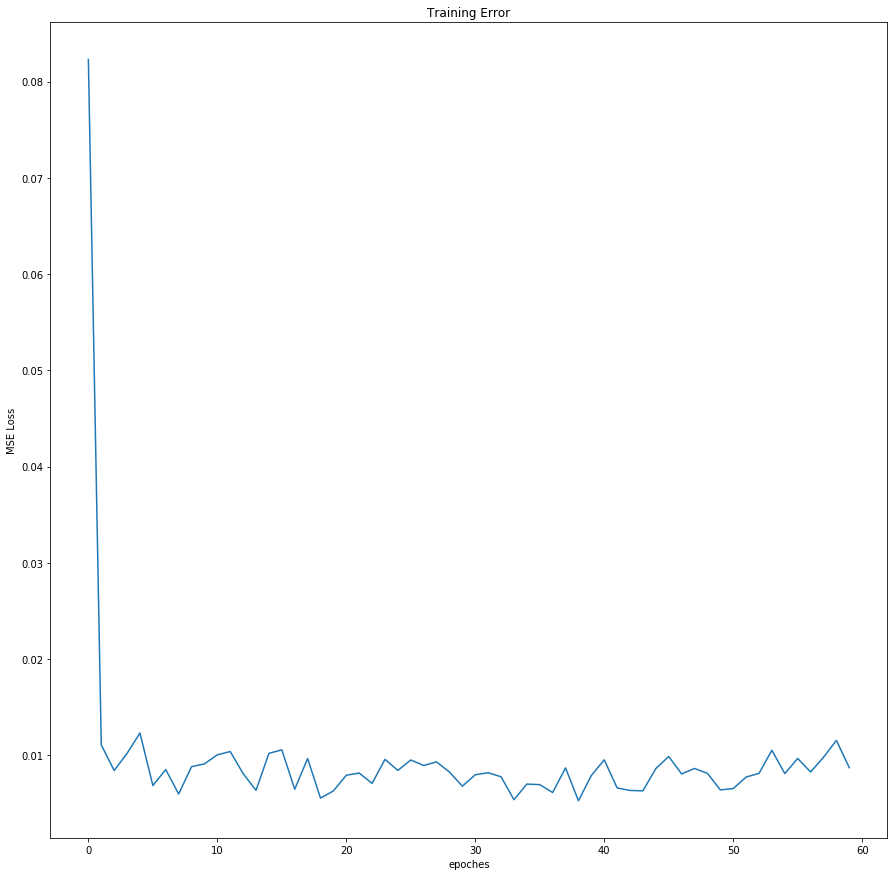

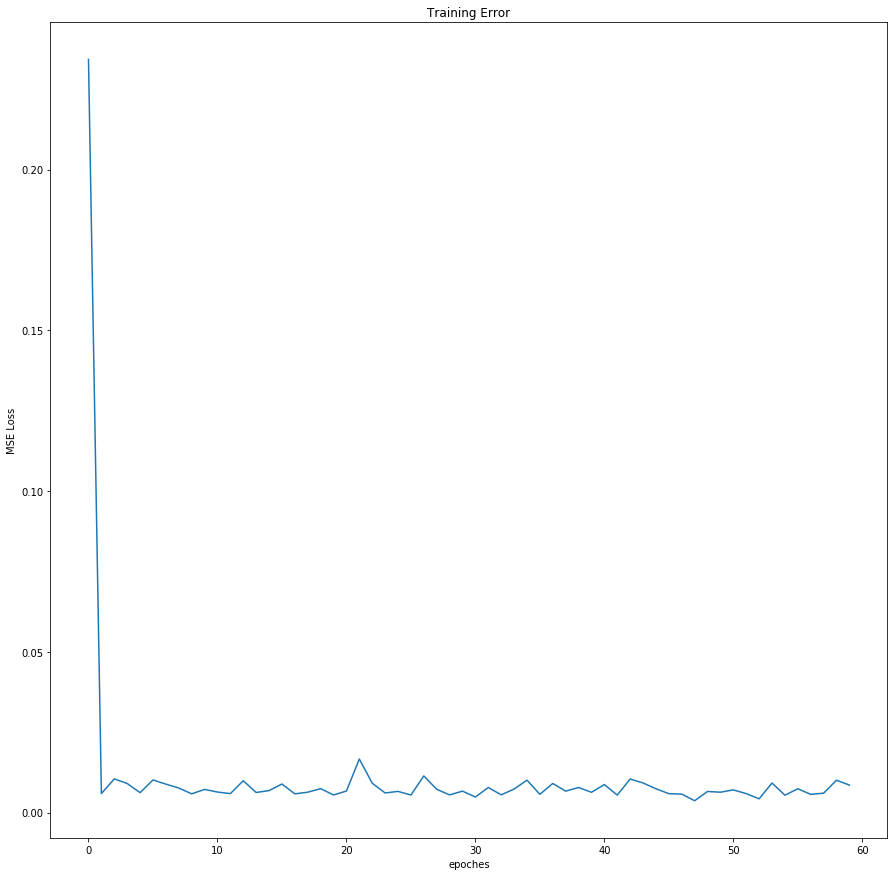

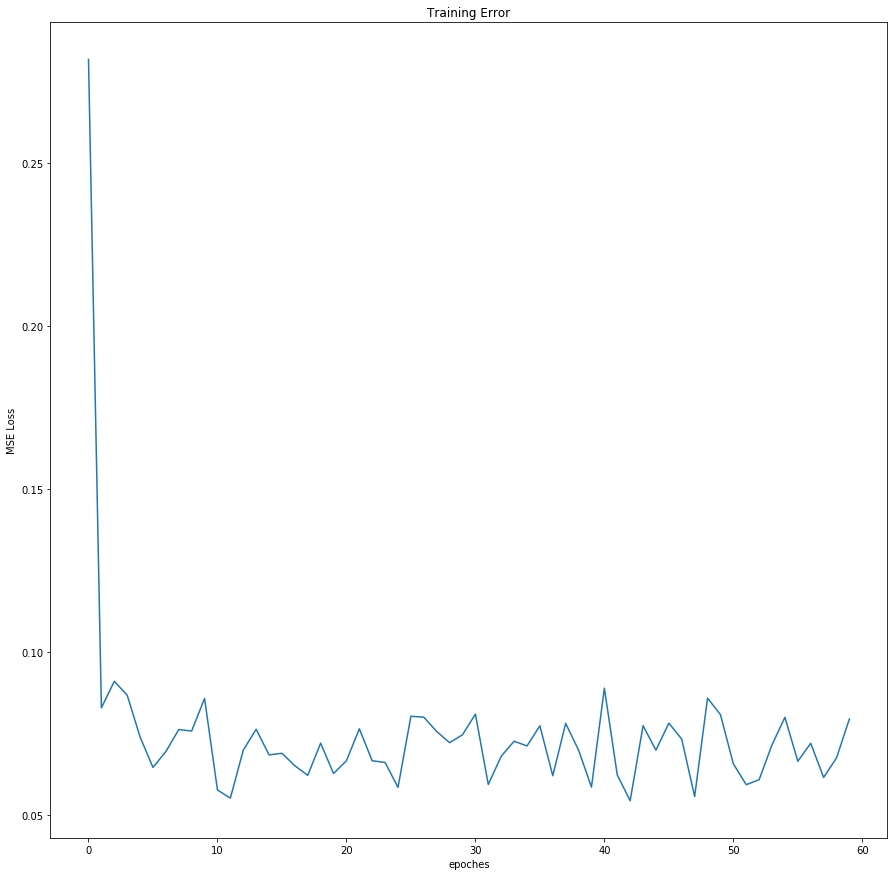

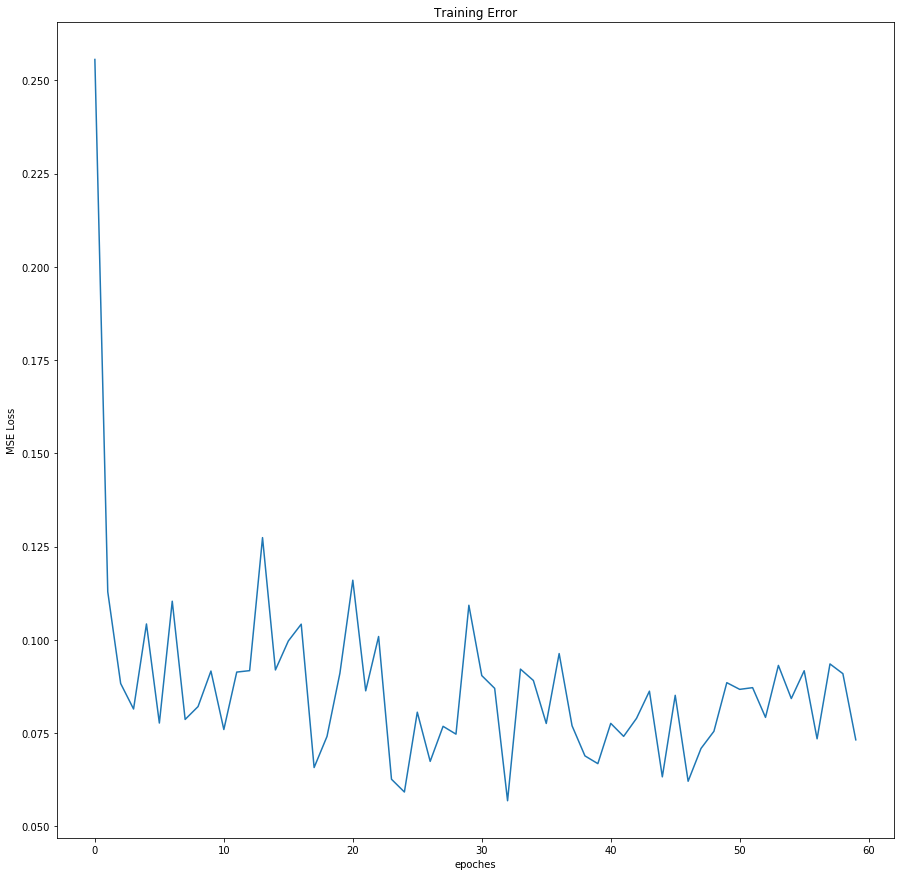

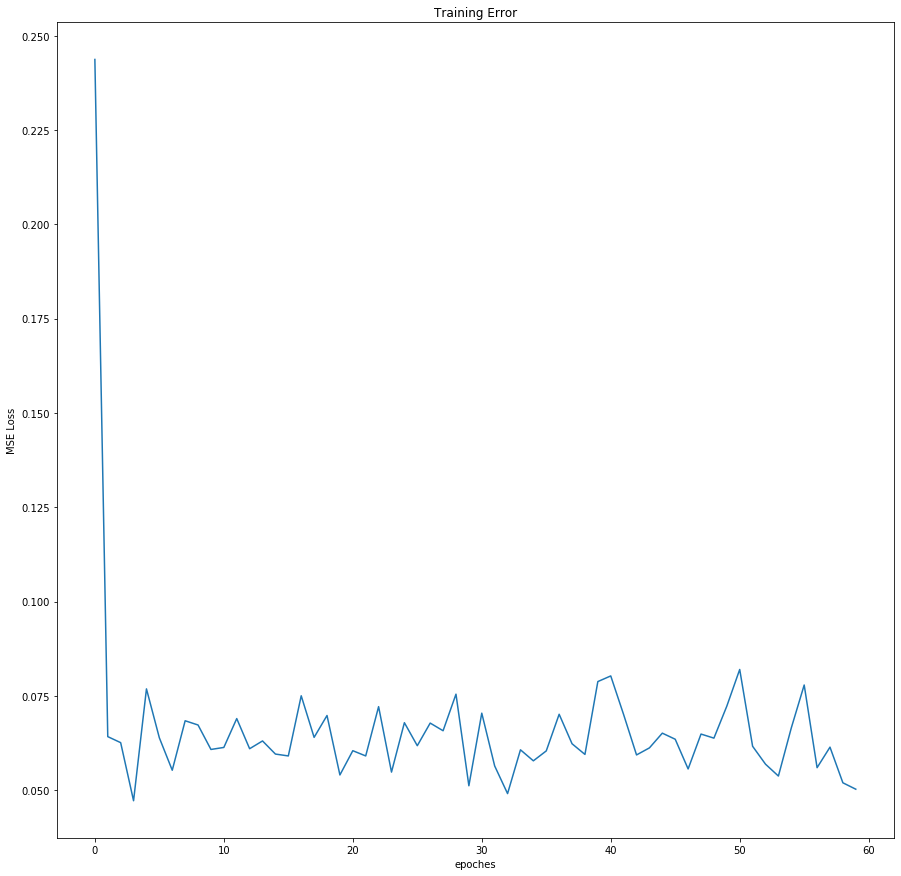

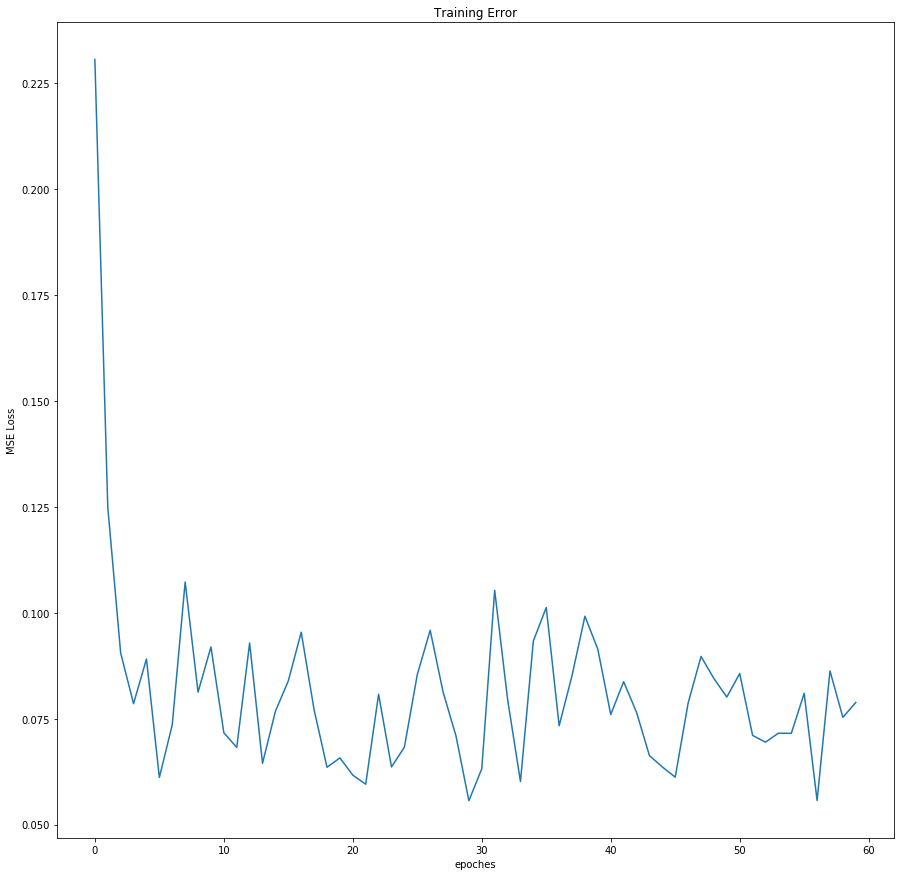

In [100]:
mse_loss=[]
for fname in sorted(os.listdir(model_base_path)):
    with open(fname+'.pickle','rb') as f:
        X=pickle.load(f)
        x=np.array(f.read().splitlines())
        y=x.astype(np.float)
        
        plt.figure(figsize=(15,15))
        plt.plot(y)
        plt.xlabel('epoches')
        plt.ylabel('MSE Loss')
        plt.title('Training Error')
        plt.show()

In [98]:
print(y.shape)

(60,)


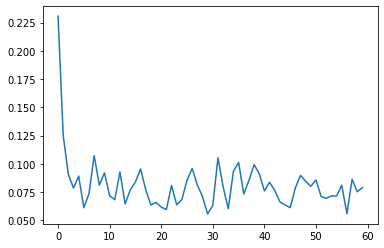